In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

In [40]:
# load the location dataset

data_path = "/content/location_data.csv"

df_reader = pd.read_csv(data_path, chunksize=100000)

df_reader

In [42]:
# do sampling.

all_samples = []

for df in df_reader:
    # Performing sampling and storing into the list.
    all_samples.append(df.sample(500))

# Concatenating all the sampled data into ones.
sample_df = pd.concat(all_samples, axis=0)

In [43]:
# size of sample df

sample_df.shape

(158000, 2)

In [44]:
sample_df

,pickup_latitude,pickup_longitude
8940,40.766136,-73.995262
38346,40.782784,-73.973976
15735,40.728352,-73.999832
62300,40.763180,-73.971703
38249,40.748775,-73.987762
...,...,...
31512712,40.755165,-73.968697
31509844,40.743530,-73.986252
31501511,40.779266,-73.983307
31514872,40.734169,-73.998863


Text(0, 0.5, 'Longitude')

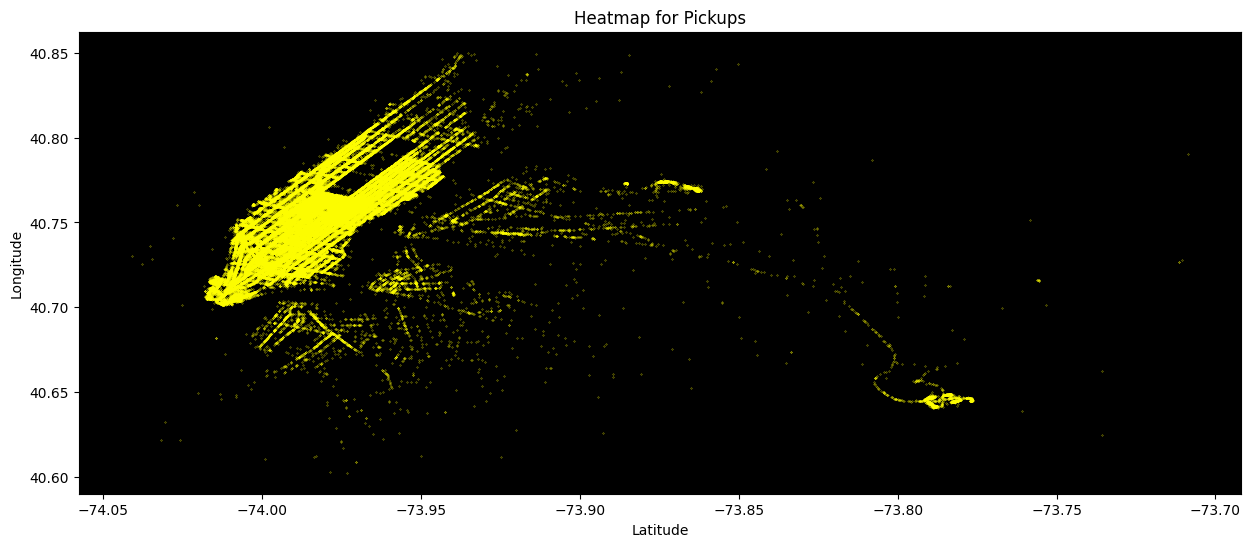

In [45]:
# plot the dataset on a scatterplot
fig, ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(15,6))

ax.set_facecolor("k")
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [46]:
from sklearn import set_config
set_config(transform_output="pandas")

In [47]:
# scale the input.
from sklearn.preprocessing import StandardScaler
scale_samples = StandardScaler()
scaled_sample_df = scale_samples.fit_transform(sample_df)
scaled_sample_df

,pickup_latitude,pickup_longitude
8940,0.550999,-0.578625
38346,1.156618,-0.011449
15735,-0.823578,-0.700395
62300,0.443447,0.049131
38249,-0.080571,-0.378792
...,...,...
31512712,0.151879,0.129227
31509844,-0.271388,-0.338540
31501511,1.028666,-0.260071
31514872,-0.611945,-0.674577


Text(0, 0.5, 'Longitude')

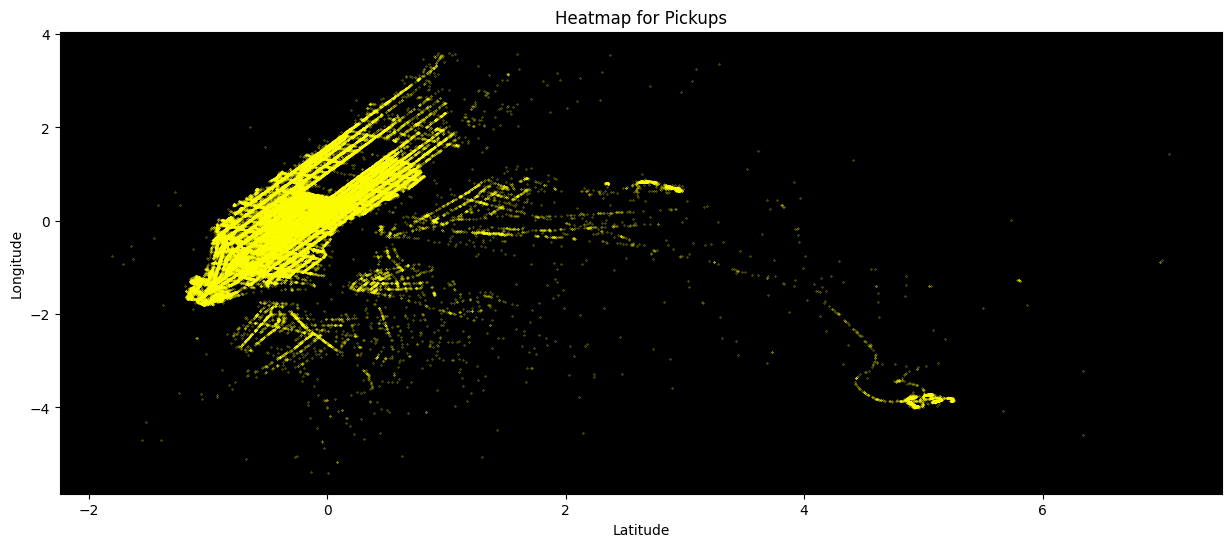

In [48]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [49]:
# Implementing the K-Means for finding the approximate number of regions.
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

df_reader = pd.read_csv(data_path, chunksize=100000)

In [50]:
df_reader

In [51]:
# train the standard scaler.
scaler = StandardScaler()
for chunk in df_reader:
    # fit the scaler.
    scaler.partial_fit(chunk)

In [52]:
scaler

StandardScaler()

In [53]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.75101618 -73.9735467 ]
The sigma values are  [0.02747379 0.03753785]


In [58]:
# Caculating the haversine distances between two points given their latitude and longitude coordinates.

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))

    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

possible_k_values = np.arange(10,100,10)

print("Possible K Values: ",possible_k_values)

def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)

        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)

            # train the model
            mini_batch.partial_fit(scaled_chunk)

        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)

        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)

        # nearby regions
        region_count = 8

        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]

        # average distances
        avg_distances = selected_distances.mean(axis=1)

        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

# select the optimum value of K

select_optimum_k(k_values=possible_k_values)

Possible K Values:  [10 20 30 40 50 60 70 80 90]
For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 4 and is 20.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 11 and is 36.7% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 10 and is 25.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 8 and is 16.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 9 and is 15.0% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 12 and is 17.1% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 15 and is 18.8% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 18 and is 20.0% regions of total


In [59]:
df_reader = pd.read_csv(data_path, chunksize=100000)

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

# centroid values
centroids = mini_batch.cluster_centers_

centroids

array([[-0.31488805, -0.24515345],
       [ 0.34495415,  1.21826336],
       [-3.83328391,  5.03775277],
       [-1.06511175, -0.43317819],
       [ 1.29598109, -0.0346267 ],
       [ 0.47363038, -0.25737602],
       [-2.34760471, -0.29250647],
       [ 1.05297646,  0.53138712],
       [-0.61597226, -0.58588549],
       [ 2.37288276,  0.57636224],
       [-0.24077504,  1.8042161 ],
       [-1.29891627,  0.50551659],
       [ 0.40081425,  0.1138959 ],
       [-0.4024403 , -0.80411378],
       [-1.48115989, -0.9853024 ],
       [-3.6932944 , -0.05094294],
       [ 1.70254637,  0.78772445],
       [ 0.68192924,  0.3957157 ],
       [ 0.10025105,  0.01301046],
       [ 0.0496057 , -0.26147602],
       [ 0.75825285,  2.77623522],
       [-0.741156  , -0.28999195],
       [-0.0999877 , -0.55209495],
       [ 0.90566732, -0.23092615],
       [-0.99869699, -0.77526621],
       [-2.24984588,  1.07799191],
       [ 1.716834  ,  0.18011049],
       [ 3.09812906,  1.08179721],
       [ 0.26930432,

In [60]:
centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

centroids.shape

centroids

array([[ 40.74236501, -73.98274923],
       [ 40.76049338, -73.9278157 ],
       [ 40.64570134, -73.78444027],
       [ 40.72175352, -73.98980728],
       [ 40.78662169, -73.97484651],
       [ 40.7640286 , -73.98320804],
       [ 40.68651858, -73.98452676],
       [ 40.77994543, -73.95359956],
       [ 40.73409308, -73.99553958],
       [ 40.81620826, -73.95191129],
       [ 40.74440117, -73.9058203 ],
       [ 40.71533002, -73.95457069],
       [ 40.76202806, -73.96927129],
       [ 40.73995962, -74.0037314 ],
       [ 40.7103231 , -74.01053283],
       [ 40.64954738, -73.97545898],
       [ 40.79779158, -73.94397721],
       [ 40.76975136, -73.95869238],
       [ 40.75377045, -73.97305831],
       [ 40.75237903, -73.98336194],
       [ 40.77184826, -73.86933278],
       [ 40.73065381, -73.98443237],
       [ 40.74826914, -73.99427116],
       [ 40.77589829, -73.98221517],
       [ 40.72357818, -74.00264853],
       [ 40.68920438, -73.93308119],
       [ 40.79818412, -73.96678573],
 

In [61]:
# calculate distances
all_distances = []
for i in centroids:
    distances = []
    for j in centroids:
        distance = haversine_distance(i[0], i[1], j[0], j[1])
        distances.append(distance)
    all_distances.append(distances)
all_distances = np.array(all_distances)

In [62]:
all_distances.shape

(30, 30)

In [63]:
# sort array
sorted_distances = np.sort(all_distances, axis=-1)

sorted_distances

array([[ 0.        ,  0.69265295,  0.72814172,  0.81395844,  0.88035962,
         0.93719955,  1.11092366,  1.22815096,  1.47129632,  1.4970188 ,
         1.53083805,  1.66446088,  2.27285831,  2.31712042,  2.38036729,
         2.64911888,  3.01156194,  3.08571499,  3.13631708,  3.85978146,
         3.9461944 ,  4.02956902,  4.33386726,  4.50082255,  5.35116519,
         6.27577722,  6.42451131,  6.98321591,  8.48819714, 12.35054906],
       [ 0.        ,  1.60052775,  1.73782887,  1.90439993,  2.17214296,
         2.41302406,  2.71226252,  2.90915381,  2.9607578 ,  3.03914994,
         3.05205681,  3.13631708,  3.15940423,  3.30742875,  3.40574107,
         3.42046853,  3.57934671,  3.61030058,  3.98680516,  4.05068909,
         4.20672109,  4.2193451 ,  4.67463242,  4.93335916,  5.23315169,
         5.54714383,  5.91128183,  6.2937788 ,  8.06167647, 10.92283863],
       [ 0.        ,  5.10780211,  8.34978825,  9.32412559,  9.78459948,
        10.01744481, 10.12980613, 10.8589987 , 10

In [64]:
# nearby regions
region_count = 8
# selected distances
selected_distances = sorted_distances[:, 1:region_count+1]
# average distances
avg_distances = selected_distances.mean(axis=1)

In [65]:
selected_distances

array([[ 0.69265295,  0.72814172,  0.81395844,  0.88035962,  0.93719955,
         1.11092366,  1.22815096,  1.47129632],
       [ 1.60052775,  1.73782887,  1.90439993,  2.17214296,  2.41302406,
         2.71226252,  2.90915381,  2.9607578 ],
       [ 5.10780211,  8.34978825,  9.32412559,  9.78459948, 10.01744481,
        10.12980613, 10.8589987 , 10.92283863],
       [ 0.67630008,  0.68414589,  0.90388039,  1.342323  ,  1.4539266 ,
         1.47129632,  1.84691864,  1.89789462],
       [ 0.83521978,  0.90334333,  1.20349212,  1.4398204 ,  1.62119818,
         1.72413253,  1.78972867,  2.164256  ],
       [ 0.63572801,  0.74233466,  0.80495648,  0.82176965,  0.88574118,
         1.23326542,  1.34245684,  1.4970188 ],
       [ 2.13566508,  2.45018802,  2.53478565,  2.59831904,  2.70172465,
         2.73086813,  3.04948819,  3.33733867],
       [ 0.75307251,  1.20349212,  1.33185122,  1.43662565,  1.48495376,
         1.52309485,  1.89994082,  1.90439993],
       [ 0.5901123 ,  0.62821997

In [66]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

np.float64(0.36666666666666664)

## **Clustering**

In [67]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [68]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [69]:
mini_batch

MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

In [70]:
# centroids of the model

mini_batch.cluster_centers_

array([[-0.31488805, -0.24515345],
       [ 0.34495415,  1.21826336],
       [-3.83328391,  5.03775277],
       [-1.06511175, -0.43317819],
       [ 1.29598109, -0.0346267 ],
       [ 0.47363038, -0.25737602],
       [-2.34760471, -0.29250647],
       [ 1.05297646,  0.53138712],
       [-0.61597226, -0.58588549],
       [ 2.37288276,  0.57636224],
       [-0.24077504,  1.8042161 ],
       [-1.29891627,  0.50551659],
       [ 0.40081425,  0.1138959 ],
       [-0.4024403 , -0.80411378],
       [-1.48115989, -0.9853024 ],
       [-3.6932944 , -0.05094294],
       [ 1.70254637,  0.78772445],
       [ 0.68192924,  0.3957157 ],
       [ 0.10025105,  0.01301046],
       [ 0.0496057 , -0.26147602],
       [ 0.75825285,  2.77623522],
       [-0.741156  , -0.28999195],
       [-0.0999877 , -0.55209495],
       [ 0.90566732, -0.23092615],
       [-0.99869699, -0.77526621],
       [-2.24984588,  1.07799191],
       [ 1.716834  ,  0.18011049],
       [ 3.09812906,  1.08179721],
       [ 0.26930432,

In [71]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.74236501, -73.98274923],
       [ 40.76049338, -73.9278157 ],
       [ 40.64570134, -73.78444027],
       [ 40.72175352, -73.98980728],
       [ 40.78662169, -73.97484651],
       [ 40.7640286 , -73.98320804],
       [ 40.68651858, -73.98452676],
       [ 40.77994543, -73.95359956],
       [ 40.73409308, -73.99553958],
       [ 40.81620826, -73.95191129],
       [ 40.74440117, -73.9058203 ],
       [ 40.71533002, -73.95457069],
       [ 40.76202806, -73.96927129],
       [ 40.73995962, -74.0037314 ],
       [ 40.7103231 , -74.01053283],
       [ 40.64954738, -73.97545898],
       [ 40.79779158, -73.94397721],
       [ 40.76975136, -73.95869238],
       [ 40.75377045, -73.97305831],
       [ 40.75237903, -73.98336194],
       [ 40.77184826, -73.86933278],
       [ 40.73065381, -73.98443237],
       [ 40.74826914, -73.99427116],
       [ 40.77589829, -73.98221517],
       [ 40.72357818, -74.00264853],
       [ 40.68920438, -73.93308119],
       [ 40.79818412, -73.96678573],
 

In [72]:
# perform predictions and assign clusters

sample_predictions = mini_batch.predict(scaled_sample_df)

sample_predictions.shape

(158000,)

In [73]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

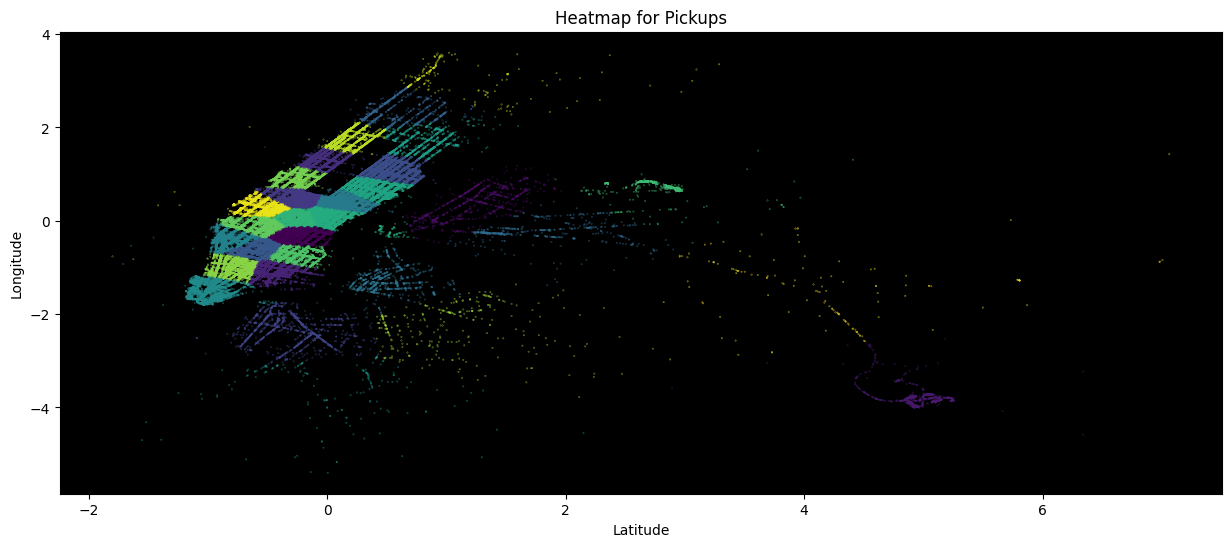

In [74]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()